# Gaussian Process Tutorial - Part 3: Application

In [1]:
# Imports
%matplotlib inline

import sys
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, cdist, squareform
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import cm
from random import sample 
import pdb
import tensorflow as tf
import gpflow

sns.set_style('darkgrid')
np.random.seed(42)
#

In [2]:
class GPR():
   
    def __init__(self, kernel, mean=None, optimizer='L-BFGS-B', noise_var=1e-8):
        self.kernel = kernel
        self.noise_var = noise_var
        self.optimizer = optimizer
    
        
    # 'Public' methods
    def sample_prior(self, X_test, mean=None, n_samples=1):
        if mean is not None:
            y_mean = mean
        else:
            y_mean = np.zeros(X_test.shape[0])
        y_cov = self.kernel(X_test)
        return self._sample_multivariate_gaussian(y_mean, y_cov, n_samples)
    
    
    def sample_posterior(self, X_train, y_train, X_test, y_train_mean=None, y_test_mean=None, n_samples=1):
        if y_train_mean is None:
            y_train_mean = np.zeros(len(y_train)).reshape((-1,1))
        if y_test_mean is None:
            y_test_mean = np.zeros(len(X_test)).reshape((-1,1))
        # compute alpha
        K_aa = self.kernel(X_train)
        K_aa[np.diag_indices_from(K_aa)] += self.noise_var
        K_aa_inv = np.linalg.solve(K_aa, np.eye(K_aa.shape[0]))
        #L = self._cholesky_factorise(K_aa)
        #alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train)) # Forward/Backward-Solve

        # Compute posterior mean
        #K_trans = self.kernel(X_test, X_train)
        K_ba = self.kernel(X_test, X_train)
        alpha = K_ba.dot(K_aa_inv)
        y_mean = y_test_mean + alpha.dot(y_train-y_train_mean)
        #y_mean = K_ba.dot(alpha)

        # Compute posterior covariance
        K_bb = self.kernel(X_test)
        K_bb[np.diag_indices_from(K_bb)] += self.noise_var
        y_cov = K_bb - alpha.dot(K_ba.T) # K_ab = K_ba-T
        #v = np.linalg.solve(L, K_ba.T)  # L.T * K_inv * K_trans.T
        #y_cov = K_bb - np.dot(v.T, v)

        return self._sample_multivariate_gaussian(y_mean, y_cov, n_samples, epsilon=1e-7), y_mean, y_cov
    
    
    def log_marginal_likelihood(self, X_train, y_train, theta, noise_var=None):
    
        if noise_var is None:
            noise_var = self.noise_var

        # Build K(X, X)
        self.kernel.theta = theta
        K = self.kernel(X_train)    
        K[np.diag_indices_from(K)] += noise_var

        # Compute L and alpha for this K (theta).
        L = self._cholesky_factorise(K)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))

        # Compute log marginal likelihood.
        log_likelihood = -0.5 * np.dot(y_train.T, alpha)
        log_likelihood -= np.log(np.diag(L)).sum()
        log_likelihood -= K.shape[0] / 2 * np.log(2 * np.pi)

        return log_likelihood
    
    
    def optimize(self, X_train, y_train):
    
        def obj_func(theta, X_train, y_train):
                return -self.log_marginal_likelihood(X_train, y_train, theta)

        results = minimize(obj_func, 
                           self.kernel.theta, 
                           args=(X_train, y_train), 
                           method=self.optimizer, 
                           jac=None,
                           bounds=self.kernel.bounds)

        # Store results of optimization.
        self.max_log_marginal_likelihood_value = -results['fun']
        self.kernel.theta_MAP = results['x']

        return results['success']
    
    
    # 'Private' helper methods
    def _cholesky_factorise(self, y_cov):
        try:
            L = np.linalg.cholesky(y_cov)
        except np.linalg.LinAlgError as e:
            e.args = ("The kernel, %s, is not returning a " 
                      "positive definite matrix. Try increasing"
                      " the noise variance of the GP or using"
                      " a larger value for epsilon. "
                      % self.kernel,) + e.args
            raise
        return L
    
    
    def _sample_multivariate_gaussian(self, y_mean, y_cov, n_samples=1, epsilon=1e-10):
        
        y_cov[np.diag_indices_from(y_cov)] += epsilon  # for numerical stability
        try:
            L = self._cholesky_factorise(y_cov)
            u = np.random.randn(y_mean.shape[0], n_samples)
            z = np.dot(L, u) + y_mean#[:, np.newaxis]
            return z
        except: 
            print("The kernel, %s, is not returning a " 
                  "positive definite matrix. Try increasing"
                  " the noise variance of the GP or using"
                  " a larger value for epsilon. ")
            return None
            




In [3]:
class WhiteNoise():
    def __init__(self, signal_variance=1.0, signal_variance_bounds=(1e-5, 1e5)):
        self.theta = [signal_variance]
        self.bounds = [signal_variance_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            K = self.theta[0] * np.eye(X1.shape[0])
        else:
            K = self.theta[0] * np.eye(X1.shape[0], X2.shape[0])
        return K

class Linear():
    def __init__(self, signal_variance=1.0, signal_variance_bounds=(1e-5, 1e5)):
        self.theta = [signal_variance]
        self.bounds = [signal_variance_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            K = self.theta[0] * np.dot(X1, X1.T)
        else:
            K = self.theta[0] * np.dot(X1, X2.T)
        return K
    

class SquaredExponential():
    def __init__(self, length_scale=1.0, sigma=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.theta = [length_scale, sigma]
        self.bounds = [length_scale_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
            dists = pdist(X1 / self.theta[0], metric='sqeuclidean')
            K = np.exp(-0.5 * dists)
            K = squareform(K)
            np.fill_diagonal(K, 1)
            K = self.theta[1]*K
        else:
            dists = cdist(X1 / self.theta[0], X2 / self.theta[0], metric='sqeuclidean')
            K = self.theta[1]*np.exp(-0.5 * dists)
            
        return K


class RationalQuadratic():
    def __init__(self, length_scale=1.0, alpha=1.0, sigma=1.0, length_scale_bounds=(1e-5, 1e5), alpha_bounds=(1e-5,1e5)):
        self.theta = [length_scale, alpha, sigma]
        self.bounds = [length_scale_bounds, alpha_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
            dists = pdist(X1 / self.theta[0]*np.sqrt(self.theta[1]), metric='sqeuclidean')
            K = (1 + dists)**(-self.theta[1])
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            dists = cdist(X1 / self.theta[0]*np.sqrt(self.theta[1]), X2 / self.theta[0]*np.sqrt(self.theta[1]), metric='sqeuclidean')
            K = (1 + dists)**(-self.theta[1])
        return self.theta[2]*K
    

class Periodic():
    def __init__(self, length_scale=1.0, period=1.0, sigma=1.0, frequency_bounds=(1e-5, 1e5)):
        self.theta = [length_scale, period, sigma]
        self.bounds = [frequency_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
            dists = pdist(X1, lambda xi, xj: np.dot(np.sin(np.pi * (xi - xj)/self.theta[1]).T/self.theta[1], 
                np.sin(np.pi * (xi - xj)/self.theta[1]))/self.theta[0])
            K = np.exp(-2*dists)
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            dists = cdist(X1, X2, lambda xi, xj: np.dot(np.sin(np.pi * (xi - xj)/self.theta[1]).T/self.theta[0], 
                np.sin(np.pi * (xi - xj)/self.theta[1]))/self.theta[0])
            K = np.exp(-2*dists)
        return self.theta[2]*K
    
#class Matern():
#    def __init__(self, length_scale=1.0, frequency=1.0, frequency_bounds=(1e-5, 1e5)):
#        self.theta = [length_scale, frequency]
#        self.bounds = [frequency_bounds]
#    def __call__(self, X1, X2=None):
#        if X2 is None:
#            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
#            dists = pdist(X1, lambda xi, xj: np.dot(np.sin(np.pi * (xi - xj)/self.theta[1]).T/self.theta[1], 
#                np.sin(np.pi * (xi - xj)/self.theta[1]))/self.theta[0])
#            K = np.exp(-2*dists)
#            K = squareform(K)
#            np.fill_diagonal(K, 1)
#        else:
#            dists = cdist(X1, X2, lambda xi, xj: np.dot(np.sin(np.pi * (xi - xj)/self.theta[1]).T/self.theta[0], 
#                np.sin(np.pi * (xi - xj)/self.theta[1]))/self.theta[0])
#            K = np.exp(-2*dists)
#        return K

In [4]:
class add_Kernels():
    def __init__(self, k1, k2):
        self.kernel1 = k1
        self.kernel2 = k2
    
    def __call__(self, X1, X2=None):
        K = self.kernel1(X1, X2) + self.kernel2(X1, X2)
        return K
    
class mult_Kernels():
    def __init__(self, k1, k2):
        self.kernel1=k1
        self.kernel2=k2
    
    def __call__(self, X1, X2=None):
        K = self.kernel1(X1, X2) * self.kernel2(X1, X2)
        return K


# Regression

## Prediction 

In [5]:
# Load the data - measurements of head acceleration in a simulated motorcycle accident,
mcycle = pd.read_csv(
   "mcycle.csv", 
    dtype=np.float64,
    sep=";",
    decimal=","
)

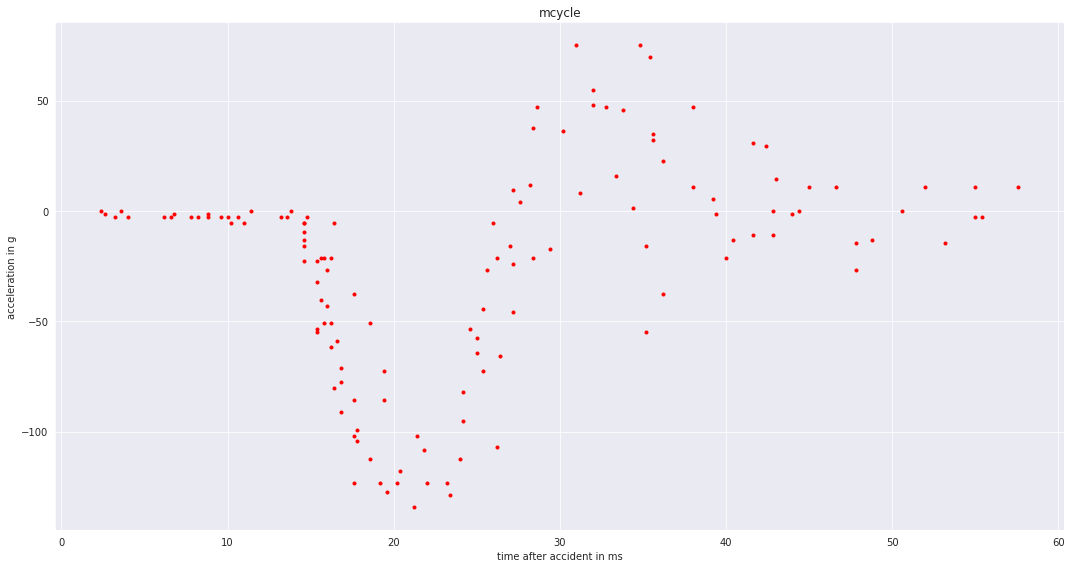

In [6]:
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.plot(mcycle['times'],mcycle['accel'], 'r.')
ax1.set_title('mcycle')
ax1.set_xlabel('time after accident in ms')
ax1.set_ylabel('acceleration in g')

plt.tight_layout()
plt.show()

In [94]:
X_train = mcycle.loc[:,"times"].ravel().reshape((-1,1))
y_train = mcycle.loc[:,"accel"].ravel().reshape((-1,1))
X_test = np.linspace(0, 70, num=200).reshape((-1,1))

In [105]:
# length_scale = 5.25, sigma = 2025, noise_var = 256
kernel = gpflow.kernels.SquaredExponential() + gpflow.kernels.White()
model = gpflow.models.GPR(data=(X_train, y_train), kernel=kernel)

In [106]:
gpflow.utilities.print_summary(model)

name                               class      transform    trainable    shape    dtype      value
---------------------------------  ---------  -----------  -----------  -------  -------  -------
GPR.kernel.kernels[0].variance     Parameter  Softplus     True         ()       float64        1
GPR.kernel.kernels[0].lengthscale  Parameter  Softplus     True         ()       float64        1
GPR.kernel.kernels[1].variance     Parameter  Softplus     True         ()       float64        1
GPR.likelihood.variance            Parameter  Softplus     True         ()       float64        1


In [107]:
model.kernel.kernels[0].variance.assign(1)
model.kernel.kernels[0].lengthscale.assign(1)
model.kernel.kernels[1].variance.assign(1)

In [108]:
f_star_mean, f_star_covar = model.predict_f(X_test)

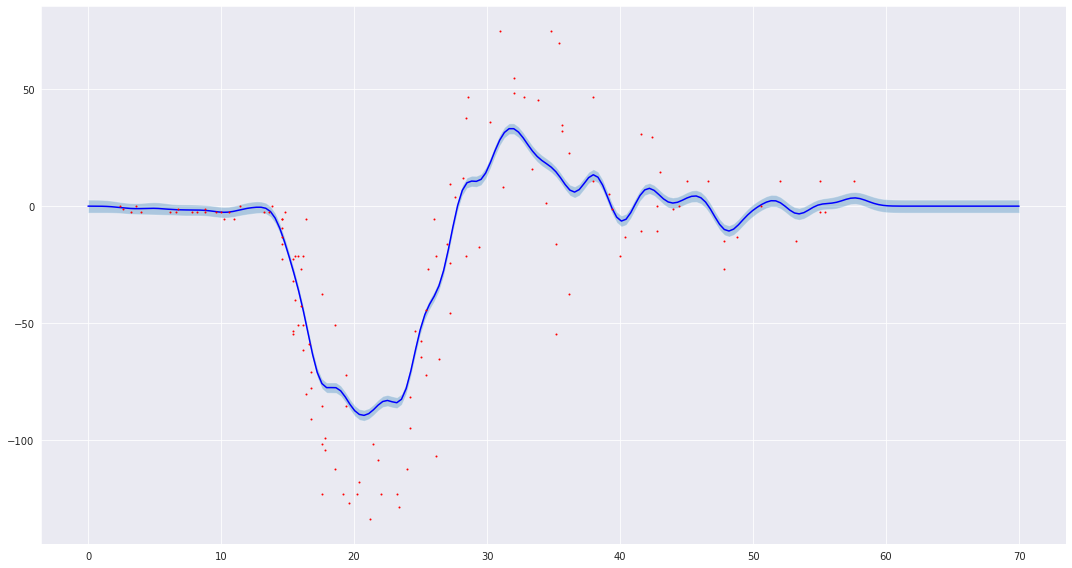

In [109]:
pointwise_variances = tf.squeeze(tf.linalg.diag(f_star_covar))
error = 1.96 * np.sqrt(pointwise_variances)

# plot
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(X_test.ravel(), tf.squeeze(f_star_mean), 'b' )
#if f_star_samples is not None:
#    ax.plot(X_test, tf.squeeze(f_star_samples), ms=2, lw=.1)
ax.fill_between(X_test.ravel(),  tf.squeeze(f_star_mean) - error,  tf.squeeze(f_star_mean) + error, alpha=0.3)
ax.plot(X_train, y_train, 'r.', ms=2)

plt.tight_layout()
plt.show()
#

In [110]:
opt = gpflow.optimizers.Scipy()

In [111]:
def objective_closure():
    return - model.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        model.trainable_variables,
                        options=dict(maxiter=1000))

In [112]:
gpflow.utilities.print_summary(model)

name                               class      transform    trainable    shape    dtype         value
---------------------------------  ---------  -----------  -----------  -------  -------  ----------
GPR.kernel.kernels[0].variance     Parameter  Softplus     True         ()       float64  2047.19
GPR.kernel.kernels[0].lengthscale  Parameter  Softplus     True         ()       float64     5.24064
GPR.kernel.kernels[1].variance     Parameter  Softplus     True         ()       float64   254.253
GPR.likelihood.variance            Parameter  Softplus     True         ()       float64   254.253


In [113]:
f_star_mean, f_star_covar = model.predict_f(X_test)

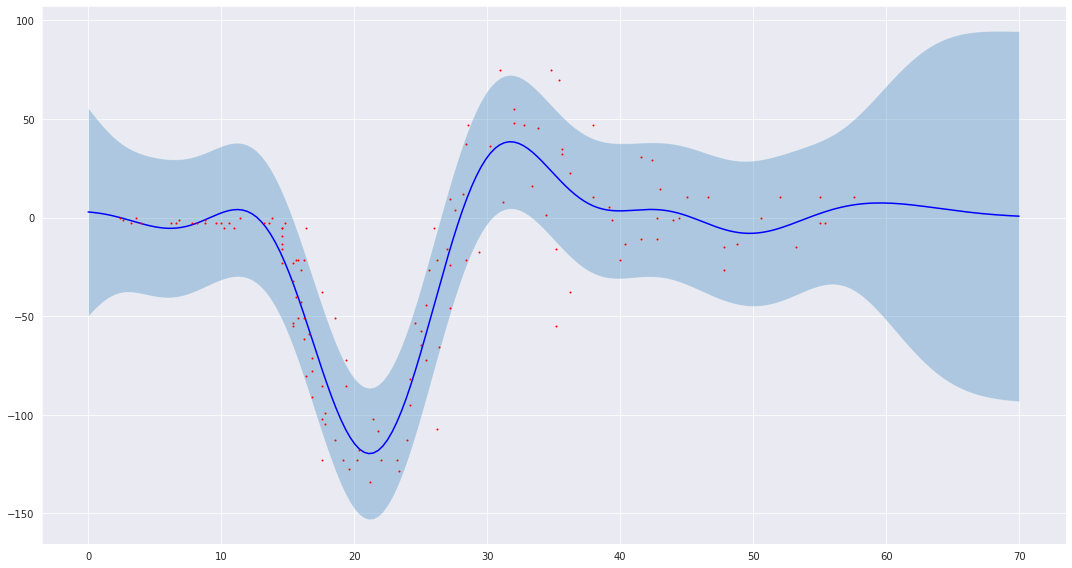

In [114]:
pointwise_variances = tf.squeeze(tf.linalg.diag(f_star_covar))
error = 1.96 * np.sqrt(pointwise_variances)

# plot
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(X_test.ravel(), tf.squeeze(f_star_mean), 'b' )
#if f_star_samples is not None:
#    ax.plot(X_test, tf.squeeze(f_star_samples), ms=2, lw=.1)
ax.fill_between(X_test.ravel(),  tf.squeeze(f_star_mean) - error,  tf.squeeze(f_star_mean) + error, alpha=0.3)
ax.plot(X_train, y_train, 'r.', ms=2)

plt.tight_layout()
plt.show()
#

## Forecasting

### Structured Modeling



### Regression

# Classification

# Structured Modeling

## Simulated Data 1

Local Kernels are not useful for extrapolation -> use Periodic Kernels

EXAMPLE WHERE ONE CAN PLAY WITH POINTS AND LENGHT SCALE

In [ ]:
# Simulate
def f(x):
    return 4 + 0.25*x+np.sin(x)

xlim=(-10,10)
X_train = np.arange(*xlim, step=2).reshape((-1,1))
y_train = f(X_train)#+0.25*np.random.randn(len(X_train)).reshape((-1,1))

xlim=(-20,20)
#X_test = np.array([[-5],[-1.5],[0],[2.25],[3], [3.2]], dtype=np.longdouble) 
X_test = np.linspace(*xlim, num=100).reshape((-1,1))

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(X_train.ravel(), y_train.ravel(), 'b+', ms=10, label='X_train')
ax.plot(X_test, np.zeros(len(X_test)).ravel(), 'r.', ms=6, label='X_test')
ax.legend(loc=1)
plt.show()
#

EXAMPLE WHERE ONE CAN PLAY WITH POINTS AND LENGHT SCALE

In [ ]:
k1 = SquaredExponential(length_scale=2) # length_scale = 1, 10, 100
k2 = Periodic(length_scale=1, period=2*np.pi)
k3 = mult_Kernels(SquaredExponential(length_scale=4), Periodic(length_scale=4, period=2*np.pi))
k4 = add_Kernels(Linear(), SquaredExponential(length_scale=1))
k5 = mult_Kernels(mult_Kernels(Linear(1), Linear(1)), Linear(1))
k6 = add_Kernels(Linear(), Periodic(length_scale=2, period=2*np.pi)) 
kernel_gp = k6
gp1 = GPR(kernel=kernel_gp)

In [ ]:
f_star_samples, f_star_mean, f_star_covar = gp1.sample_posterior(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    n_samples=100)

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(8, 3))
if f_star_samples is not None:
    ax.plot(X_test, f_star_samples, ms=2, lw=.1)
ax.plot(X_test.ravel(), f_star_mean.ravel(), 'b-', ms=10)
ax.plot(X_train, y_train, 'r+', ms=6)
ax.plot(X_test, f(X_test), 'r-', lw=.1)
plt.show()
#

## Simulated Data 2

In [ ]:
# Simulate
def f(x):
    return 4+ 0.25*x+np.sin(x)

xlim=(-10,10)
X_train = np.arange(*xlim, step=2).reshape((-1,1))
y_train = f(X_train)#+0.25*np.random.randn(len(X_train)).reshape((-1,1))

xlim=(-40,40)
#X_test = np.array([[-5],[-1.5],[0],[2.25],[3], [3.2]], dtype=np.longdouble) 
X_test = np.linspace(*xlim, num=100).reshape((-1,1))

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(X_train.ravel(), y_train.ravel(), 'b+', ms=10, label='X_train')
ax.plot(X_test, np.zeros(len(X_test)).ravel(), 'r.', ms=6, label='X_test')
ax.legend(loc=1)
plt.show()
#

In [ ]:
from sklearn import gaussian_process, linear_model
from sklearn.gaussian_process.kernels import (Matern,
                                              WhiteKernel,
                                              ConstantKernel,
                                              RBF,
                                              ExpSineSquared,
                                              RationalQuadratic
                                             )

In [ ]:
k1 = ConstantKernel()
k2 = RBF(length_scale=1)
k3 = ExpSineSquared(periodicity=2*np.pi)
k4 = RBF(length_scale=6)*ExpSineSquared(periodicity=2*np.pi)
kernel_gp = RBF(length_scale=2)+RBF(length_scale=100)

In [ ]:
gp2 = gaussian_process.GaussianProcessRegressor(kernel=kernel_gp)
gp2.fit(X_train, y_train)
print(gp2.kernel_)
y_pred, sigma = gp2.predict(X_test, return_std=True)


In [ ]:
error = (1.96 * sigma).reshape(-1,1)

# plot
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(X_test.ravel(), y_pred.ravel(), 'b-' )
ax.fill_between(X_test.ravel(), y_pred.ravel() - error.ravel(), y_pred.ravel() + error.ravel(), alpha=0.3)
ax.plot(X_train, y_train, 'r+', ms=10)
plt.show()
#

## Simulated Motorcycle Accident 

In [ ]:
# Load the data
# measurements of head acceleration in a simulated motorcycle accident,
mcycle = pd.read_csv(
   "mcycle.csv", 
    dtype=np.float64,
    sep=";",
    decimal=","
)

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(mcycle['times'],mcycle['accel'], 'r.')
ax1.set_title('mcycle')

plt.tight_layout()
plt.show()

In [ ]:
X_train = mcycle.loc[:,"times"].ravel().reshape((-1,1))
y_train = mcycle.loc[:,"accel"].ravel().reshape((-1,1))
X_test = np.linspace(0, 70, num=200).reshape((-1,1))

In [ ]:
# length_scale = 3, sigma = 1, noise_var = 2
k1 = WhiteNoise(1)
k2 = SquaredExponential(length_scale=5.25, sigma=2025)
k3 = SquaredExponential(length_scale=5, sigma=1)
k4 = add_Kernels(k2, k3)
gp1 = GPR(kernel=k2, noise_var=256)


In [ ]:
f_star_samples, f_star_mean, f_star_covar = gp1.sample_posterior(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    n_samples=1)

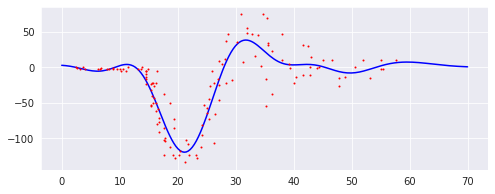

In [84]:
#pointwise_variances = f_star_covar.diagonal()
#error = 1.96 * np.sqrt(pointwise_variances)

# plot
fig, ax = plt.subplots(figsize=(15, 3))

ax.plot(X_test.ravel(), tf.squeeze(f_star_mean), 'b' )
#if f_star_samples is not None:
#    ax.plot(X_test, f_star_samples, ms=2, lw=.1)
#ax.fill_between(X_test.ravel(), f_star_mean.ravel() - error.ravel(), f_star_mean.ravel() + error.ravel(), alpha=0.3)
ax.plot(X_train, y_train, 'r.', ms=2)



plt.show()
#

In [ ]:
# Create coordinates in parameter space at which to evaluate the lml.
length_scales = np.linspace(0.5, 10, 50)
sigma = np.linspace(1, 2000, 100)
noise_variance = np.linspace(1, 300, 100)
X, Y, Z = np.meshgrid(length_scales, sigma, noise_variance)

In [ ]:
# Evaluate the lml at these coordinates.
Z = np.array(list(map(lambda x: gp1.log_marginal_likelihood(X_train, y_train, theta=[x[0], x[1]], noise_var=x[2]), list(zip(X.ravel(), Y.ravel(), Z.ravel())))))
Z = Z.reshape((X.shape))

In [ ]:
print(gp1.kernel.theta)
print(gp1.noise_var)


In [ ]:
f_star_samples, f_star_mean, f_star_covar = gp1.sample_posterior(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    n_samples=1)

In [ ]:
pointwise_variances = f_star_covar.diagonal()
error = 1.96 * np.sqrt(pointwise_variances)

# plot
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(X_test.ravel(), f_star_mean.ravel(), 'b' )
# if f_star_samples is not None:
#    ax.plot(X_test, f_star_samples, ms=2, lw=.1)
ax.fill_between(X_test.ravel(), f_star_mean.ravel() - error.ravel(), f_star_mean.ravel() + error.ravel(), alpha=0.3)
ax.plot(X_train, y_train, 'r.', ms=2)

plt.show()
#

## AirPassenger

As a first real world example we will fit a GP to the airline passenger dataset. (Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. Third Edition. Holden-Day. Series G.).

In [ ]:
from sklearn import gaussian_process, linear_model
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, ExpSineSquared, RationalQuadratic

In [ ]:
# Air Passenger Data
y=np.array([112, 118, 132, 129, 121,135, 148, 148, 136, 119, 104, 118,
 115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140,
 145, 150, 178, 163, 172, 178, 199, 199, 184, 162, 146, 166,
 171, 180, 193, 181, 183, 218, 230, 242, 209, 191, 172, 194,
 196, 196, 236, 235, 229, 243, 264, 272, 237, 211, 180, 201,
 204, 188, 235, 227, 234, 264, 302, 293, 259, 229, 203, 229,
 242, 233, 267, 269, 270, 315, 364, 347, 312, 274, 237, 278,
 284, 277, 317, 313, 318, 374, 413, 405, 355, 306, 271, 306,
 315, 301, 356, 348, 355, 422, 465, 467, 404, 347, 305, 336,
 340, 318, 362, 348, 363, 435, 491, 505, 404, 359, 310, 337,
 360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405,
 417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432]).reshape((-1,1))
X=np.arange(y.shape[0]).reshape((-1,1))

date=pd.date_range('1949-01-01','1960-12-01', 
              freq='MS')

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(date, y)
ax1.set_title('AirPassenger')

ax2.plot(date, np.log(y))
ax2.set_title('Log AirPassenger')

plt.tight_layout()
plt.show()

Due to the increasing variance we fit a GP to the log-transformed data. MEAN FUNCTION!

Using the [marginalisation property](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Marginal_distributions) of multivariate Gaussians, the joint distribution over the observations, $\mathbf{y}$, and test outputs $\mathbf{f_*}$ according to the GP prior is
$$\begin{bmatrix} \mathbf{y} \\ \mathbf{f}_* \end{bmatrix} = \mathcal{N}\left(\begin{bmatrix} \mu_{y}\\ \mu_{\mathbf{f}_*}\end{bmatrix}, \begin{bmatrix} K(X, X)  + \sigma_n^2I && K(X, X_*) \\ K(X_*, X) && K(X_*, X_*)\end{bmatrix}\right).$$

FORMEL ANPASSEN

The GP posterior is found by conditioning the joint G.P prior distribution on the observations
$$\mathbf{f}_* | X_*, X, \mathbf{y} \sim \mathcal{N}\left(\bar{\mathbf{f}}_*, \text{cov}(\mathbf{f}_*)\right),$$

where 
\begin{align*}
\bar{\mathbf{f}}_* &= K(X_*, X)\left[K(X, X) + \sigma_n^2\right]^{-1}\mathbf{y} \\
\text{cov}(\mathbf{f}_*) &= K(X_*, X_*) - K(X_*, X)\left[K(X, X) + \sigma_n^2\right]^{-1}K(X, X_*).
\end{align*}

Although $\bar{\mathbf{f}}_*$ and $\text{cov}(\mathbf{f}_*)$ look nasty, they follow the the standard form for the mean and covariance of a conditional Gaussian distribution, and can be derived relatively straightforwardly (see [here](https://stats.stackexchange.com/questions/30588/deriving-the-conditional-distributions-of-a-multivariate-normal-distribution)).

In [ ]:
h=24
X_train=X[:-h]
X_test=np.arange(-h,len(X_train)+h).reshape((-1,1))
y_train=np.log(y)[:-h]

In [ ]:
k1 = WhiteNoise(3)
k2 = mult_Kernels(RBF(), Periodic(period=12))
k3 = add_Kernels(Linear(), k2)
k4 = add_Kernels(k1, k3)
gp1 = GPR(kernel=k4)


In [ ]:
f_star_samples, f_star_mean, f_star_covar = gp1.sample_posterior(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    n_samples=1)

In [ ]:
pointwise_variances = f_star_covar.diagonal()
error = 1.96 * np.sqrt(pointwise_variances)
#plt.fill_between(X_test[:, 0], f_star_mean - error, f_star_mean + error, alpha=0.3)

# plot
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(X_test.ravel(), f_star_mean.ravel(), 'b' )
#ax.fill_between(X_train.ravel(), f_star_mean.ravel() - error.ravel(), f_star_mean.ravel() + error.ravel(), alpha=0.3)
ax.plot(X_train, y_train, 'r-', ms=2)
plt.show()
#

The higer the length scale of the SquaredExponential, the slower the covariance decreases.

In [ ]:
k1 = ConstantKernel()

In [ ]:
k2 = RBF(length_scale=1)*ExpSineSquared(length_scale=1, periodicity=12)

In [ ]:
#k3 = RBF(length_scale=90)*ExpSineSquared(length_scale=1, periodicity=12)

In [ ]:
k4 =  WhiteKernel(noise_level=1)

In [ ]:
kernel_gp = k1+k2+k4

In [ ]:
GPR = gaussian_process.GaussianProcessRegressor(kernel=kernel_gp)
GPR.fit(X_train, y_train)
print(GPR.kernel_)
#X_test = np.arange(y.shape[0], y.shape[0]+24).reshape(-1,1)
y_pred, sigma = GPR.predict(X_test, return_std=True)
error = (1.96 * sigma).reshape(-1,1)

# plot
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(X_test.ravel(), y_pred.ravel(), 'b' )
#ax.fill_between(X_train.ravel(), y_pred.ravel() - error.ravel(), y_pred.ravel() + error.ravel(), alpha=0.3)
ax.plot(X_train, y_train, 'r-', ms=2)
plt.show()
#

## Mauna Loa CO₂ data

Source Rasmussen Williams

In [ ]:
# Load the data
# Load the data from the Scripps CO2 program website. 
co2_df = pd.read_csv(
    # Source: https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv
    './monthly_in_situ_co2_mlo.csv', 
    header=54, # Data starts here
    skiprows=[55, 56], # Headers consist of multiple rows
    usecols=[3, 4], # Only keep the 'Date' and 'CO2' columns
    na_values='-99.99',  # NaNs are denoted as '-99.99'
    dtype=np.float64
)

# Drop missing values
co2_df.dropna(inplace=True)
# Remove whitespace from column names
co2_df.rename(columns=lambda x: x.strip(), inplace=True)
#

In [ ]:
# Plot data
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(co2_df.Date, co2_df.CO2)
plt.show()
#

periodic, non-stationary, no reason to assum perfect periodicity, noise

In [ ]:
X_train = co2_df.iloc[:,0].ravel().reshape((-1,1))
X_test = np.linspace(1959, 2030, num = 71*12).reshape((-1, 1))
y_train = co2_df.iloc[:,1].ravel().reshape((-1,1))


In [ ]:
# Squared Exponential

# Locally Periodic 

# Rational Quadratic

In [ ]:
# Rasmussen and Williams

k1 = SquaredExponential(sigma = 66, length_scale=67)
k2 = mult_Kernels(SquaredExponential(sigma=2.4, length_scale=90), Periodic(length_scale=1.0, period=1.3))
k3 = RationalQuadratic(sigma=0.66, length_scale=1.2, alpha=0.78)
k4 = mult_Kernels(SquaredExponential(sigma=0.18, length_scale=1.6), WhiteNoise(0.19))
k5 = add_Kernels(k1, k2)
k6 = add_Kernels(k3, k4)
k6 = add_Kernels(k5, k6)

gp1 = GPR(kernel=k7)


In [ ]:
#k1 = mult_Kernels(Linear(), SquaredExponential(length_scale=100))
#k2 = mult_Kernels(SquaredExponential(length_scale=2), Periodic())
#k3 = mult_Kernels(SquaredExponential(), RationalQuadratic())
#k4 = add_Kernels(k1, k2)
#k5 = add_Kernels(k3, k4)
#k6 = add_Kernels(k5, WhiteNoise())
#gp1 = GPR(kernel=k6)




In [ ]:
f_star_samples, f_star_mean, f_star_covar = gp1.sample_posterior(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    n_samples=1)

In [ ]:
pointwise_variances = f_star_covar.diagonal()
error = 1.96 * np.sqrt(pointwise_variances)

# plot
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(X_test.ravel(), f_star_mean.ravel(), 'b' )

if f_star_samples is not None:
    ax.plot(X_test, f_star_samples, ms=2, lw=.1)
ax.plot(X_train, y_train, 'r-', ms=2)
plt.show()
#

#### scikit-learn

In [ ]:
k1 = ConstantKernel()#*ConstantKernel()
k2 = RBF(length_scale=2)*ExpSineSquared(length_scale=.5, periodicity=12)
k3 = RBF(length_scale=100)
k4 = RBF(length_scale=1)
k5 =  WhiteKernel(noise_level=1)
kernel_gp = k1 + k2 + k5

In [ ]:
gpr = gaussian_process.GaussianProcessRegressor(kernel=kernel_gp)
gpr.fit(X_train, y_train)
print(gpr.kernel_)
y_pred, sigma = gpr.predict(X_test, return_std=True)


In [ ]:
error = (1.96 * sigma).reshape(-1,1)
# plot
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(X_test.ravel(), y_pred.ravel(), 'b' )
#ax.fill_between(X_train.ravel(), y_pred.ravel() - error.ravel(), y_pred.ravel() + error.ravel(), alpha=0.3)
ax.plot(X_train, y_train, 'r-', ms=2)
plt.show()
#

In [ ]:
34.4**2 * RBF(length_scale=41.8)
+ 3.27**2 * RBF(length_scale=180) * ExpSineSquared(length_scale=1.44,
                                                   periodicity=1)
+ 0.446**2 * RationalQuadratic(alpha=17.7, length_scale=0.957)
+ 0.197**2 * RBF(length_scale=0.138) + WhiteKernel(noise_level=0.0336)

## GPflow

In [ ]:
from typing import Tuple, Optional
from pathlib import Path

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow

from gpflow.config import default_float

import warnings

warnings.filterwarnings('ignore')


In [ ]:
output_logdir = "/tmp/tensorboard"

!rm -rf "{output_logdir}"
!mkdir "{output_logdir}"

%load_ext tensorboard
%matplotlib inline


def enumerated_logdir(_logdir_id: int = [0]):
    logdir = Path(output_logdir, str(_logdir_id[0]))
    _logdir_id[0] += 1
    return str(logdir)

In [ ]:


gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)



In [ ]:
def noisy_sin(x): 
    return tf.math.sin(x) + 0.1 * tf.random.normal(x.shape, dtype=default_float())

num_train_data, num_test_data = 100, 500

X = tf.random.uniform((num_train_data, 1), dtype=default_float()) * 10
Xtest = tf.random.uniform((num_test_data, 1), dtype=default_float()) * 10

Y = noisy_sin(X)
Ytest = noisy_sin(Xtest)

data = (X, Y)

plt.plot(X, Y, 'xk')
plt.show()

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
test_dataset = tf.data.Dataset.from_tensor_slices((Xtest, Ytest))

batch_size = 32
num_features = 10
prefetch_size = num_train_data // 2
shuffle_buffer_size = num_train_data // 2
num_batches_per_epoch = num_train_data // batch_size

original_train_dataset = train_dataset
train_dataset = train_dataset.repeat()\
                    .prefetch(prefetch_size)\
                    .shuffle(buffer_size=shuffle_buffer_size)\
                    .batch(batch_size)

print(f"prefetch_size={prefetch_size}")
print(f"shuffle_buffer_size={shuffle_buffer_size}")
print(f"num_batches_per_epoch={num_batches_per_epoch}")

In [ ]:
kernel = gpflow.kernels.RBF(variance=2.)
likelihood = gpflow.likelihoods.Gaussian()
inducing_variable = np.linspace(0, 10, num_features).reshape(-1, 1)

model = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable)

In [ ]:
from gpflow.utilities import set_trainable

set_trainable(likelihood, False)
set_trainable(kernel.variance, False)

set_trainable(likelihood, True)
set_trainable(kernel.variance, True)

In [ ]:
kernel.lengthscale.assign(0.5)

In [ ]:
from gpflow.utilities import print_summary

print_summary(model)  # same as print_summary(model, fmt="simple")

In [ ]:
gpflow.config.set_default_summary_fmt("notebook")

print_summary(model)  # same as print_summary(model, fmt="notebook")

In [ ]:


optimizer = tf.optimizers.Adam()

with tf.GradientTape() as tape:
    tape.watch(model.trainable_variables)
    obj = - model.elbo(data)
    grads = tape.gradient(obj, model.trainable_variables)
    
optimizer.apply_gradients(zip(grads, model.trainable_variables))



In [ ]:
def optimization_step(model: gpflow.models.SVGP, batch: Tuple[tf.Tensor, tf.Tensor]):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        obj = - model.elbo(batch)
        grads = tape.gradient(obj, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
def simple_training_loop(model: gpflow.models.SVGP, epochs: int = 1, logging_epoch_freq: int = 10):
    batches = iter(train_dataset)
    tf_optimization_step = tf.function(optimization_step, autograph=False)
    for epoch in range(epochs):
        for _ in range(num_batches_per_epoch):
            tf_optimization_step(model, next(batches))

        epoch_id = epoch + 1
        if epoch_id % logging_epoch_freq == 0:
            tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(data)}")

In [ ]:
from intro_to_gpflow2_plotting import plotting_regression, summary_matplotlib_image

samples_input = tf.cast(np.linspace(0, 10, 100).reshape(100, 1), default_float())

def monitored_training_loop(model: gpflow.models.SVGP, logdir: str, 
                            epochs: int = 1, logging_epoch_freq: int = 10,
                            num_samples: int = 10):
    summary_writer = tf.summary.create_file_writer(logdir)
    tf_optimization_step = tf.function(optimization_step)
    batches = iter(train_dataset)

    with summary_writer.as_default():
        for epoch in range(epochs):
            for _ in range(num_batches_per_epoch):
                tf_optimization_step(model, next(batches))

            epoch_id = epoch + 1
            if epoch_id % logging_epoch_freq == 0:
                tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(data)}")

                mean, var = model.predict_f(samples_input)
                samples = model.predict_f_samples(samples_input, num_samples)
                fig = plotting_regression(X, Y, samples_input, mean, var, samples)
                
                summary_matplotlib_image(dict(model_samples=fig), step=epoch)
                tf.summary.scalar('elbo', data=model.elbo(data), step=epoch)
                tf.summary.scalar('likelihood/variance', data=model.likelihood.variance, step=epoch)
                tf.summary.scalar('kernel/lengthscale', data=model.kernel.lengthscale, step=epoch)
                tf.summary.scalar('kernel/variance', data=model.kernel.variance, step=epoch)

In [ ]:
model = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable)

output_logdir = enumerated_logdir()
monitored_training_loop(model, output_logdir, epochs=1000, logging_epoch_freq=100)